# Building coilsPy from scratch 

## Step 1: Normalized Generation Scheme
First we need a reliable way of generating a tensor of complex numbers that sum to be some specified point along the complex unit circle. To help, let's use a simple function to plot out complex tensors tip-to-tail to ensure they meet this criteria.

In [457]:
import matplotlib.pyplot as plt
import numpy as np

def plot_complex_vectors(complex_array):
    # Plot the unit circle
    angles = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(angles), np.sin(angles), linestyle='dotted')

    # Starting point for the vectors
    start = 0 + 0j
    for z in complex_array:
        # Plot each vector
        end = start + z
        plt.arrow(start.real, start.imag, z.real, z.imag,
                  head_width=0.05, head_length=0.05, length_includes_head=True)
        start = end

    # Set equal scaling and labels
    plt.axis('equal')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.grid(True)
    plt.title('Complex Vectors Summation')

    # Show the plot
    plt.show()

There are a number of ways I can accomplish our needs, but currently I am using the following approach:

C:\Users\johnm\AppData\Local\Temp\ipykernel_20916\3711926490.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotated_complex_numbers = torch.tensor(rotated_complex_numbers, dtype=torch.complex128)


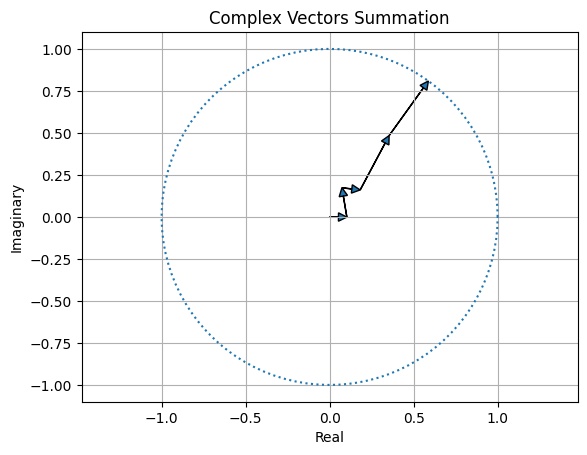

In [458]:
import torch

def dirichlet_to_goal(goal_value, num_elements, alpha=1.0):
    rand_samples = torch.distributions.Dirichlet(torch.full((num_elements,), alpha / num_elements)).sample()
    rand_samples -= rand_samples.mean()
    rand_samples += goal_value/num_elements

    return rand_samples

def generate_complex_sum(goal_theta, num_elements=5, alpha_0 = 1.0, alpha_1 = 1.0):
    real_goal = torch.cos(goal_theta)
    imag_goal = torch.sin(goal_theta)
    real_parts = torch.distributions.Dirichlet(torch.full((num_elements,), alpha_0 / num_elements)).sample()
    imag_parts = dirichlet_to_goal(0, num_elements, alpha_1)
    complex_numbers = torch.complex(real_parts, imag_parts)
    
    # Step 4: Rotate the entire set of vectors by the goal theta
    rotated_complex_numbers = complex_numbers * (real_goal + imag_goal * 1j)
    
    rotated_complex_numbers = torch.tensor(rotated_complex_numbers, dtype=torch.complex128)

    return rotated_complex_numbers

# Example usage
theta = torch.tensor([0.3 * torch.pi])  # 90 degrees, should sum to i
complex_array = generate_complex_sum(theta, num_elements = 5, alpha_0= 10.0, alpha_1= 10.0)
plot_complex_vectors(complex_array.numpy())

## Initial State Generation

This function alone is sufficient for generating our initial state, so let's make some helper functions to generate our initial transition tensor and interaction tensor. 

In [459]:
# Transition tensor create:
def initialize_transition_tensor(num_elements,theta):
    # Create a list to store each column
    columns = []
    num_columns = num_elements

    for _ in range(num_columns):
        column = generate_complex_sum(theta, num_elements = num_elements, alpha_0= 10.0, alpha_1= 10.0)
        columns.append(column.unsqueeze(1))  # Add a dimension to make it a column

    # Combine columns into a matrix
    transition_tensor = torch.cat(columns, dim=1)
    
    return transition_tensor

In [460]:
# Interaction Tensor Create:
def initialize_interaction_tensor(num_elements,theta):
    # Example usage
    num_3d_tensors = num_elements + 1  # Number of 3D tensors in the 4D tensor
    num_matrices = num_elements  # Number of 2D matrices in each 3D tensor
    num_columns = num_elements  # Number of columns in each 2D matrix
    goal_theta = torch.tensor([0.5 * torch.pi], dtype=torch.float32)  # Example goal theta

    # Create a list to store each 3D tensor
    tensors_3d = []

    for _ in range(num_3d_tensors):
        matrices = []
        for _ in range(num_matrices):
            columns = []
            for _ in range(num_columns):
                column = generate_complex_sum(theta, num_elements = num_elements, alpha_0= 1.0, alpha_1= 10.0)
                columns.append(column.unsqueeze(1))  # Add a dimension to make it a column
            matrix = torch.cat(columns, dim=1)
            matrices.append(matrix.unsqueeze(1))  # Add a dimension to make it a 2D matrix
        tensor_3d = torch.cat(matrices, dim=1)
        tensors_3d.append(tensor_3d)

    # Combine 3D tensors into a 4D tensor
    # Stack along the fourth dimension
    interaction_tensor = torch.stack(tensors_3d, dim=3)
    
    return interaction_tensor

Now we can generate all the starting states:

In [461]:
num_elements = 5

# Thetas for state, transition, and interactions
angles_dict = {
    'state': 0.3,
    'transition': 0.2,
    'interaction': 0.4
}

thetas_dict = {key : torch.tensor([value * torch.pi]) for key, value in angles_dict.items()}

# Establish state_tensor
state_tensor = generate_complex_sum(thetas_dict['state'], num_elements = num_elements, alpha_0= 1.0, alpha_1= 10.0)
transition_tensor = initialize_transition_tensor(theta = thetas_dict['transition'], num_elements = num_elements)
interaction_tensor = initialize_interaction_tensor(theta = thetas_dict['transition'], num_elements = num_elements)

# Move everything to GPU
state_tensor = state_tensor.to('cuda:0')
transition_tensor = transition_tensor.to('cuda:0')
interaction_tensor = interaction_tensor.to('cuda:0')

state_tensor.device

C:\Users\johnm\AppData\Local\Temp\ipykernel_20916\3711926490.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotated_complex_numbers = torch.tensor(rotated_complex_numbers, dtype=torch.complex128)


device(type='cuda', index=0)

In [462]:
print("CUDA GPU:", torch.cuda.is_available())

CUDA GPU: True


## Normalization testing
Let's first do some quick tests to make sure our normalization is working as intended

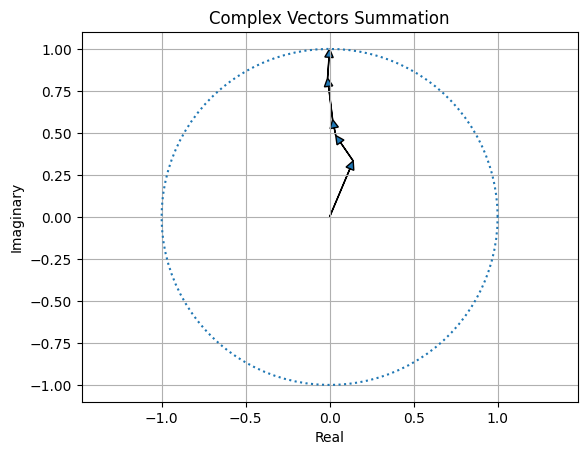

In [463]:
# First just checking that our initial transition tensor looks good:
new_state_tensor = torch.matmul(transition_tensor,state_tensor)

plot_complex_vectors(new_state_tensor.to('cpu').numpy())

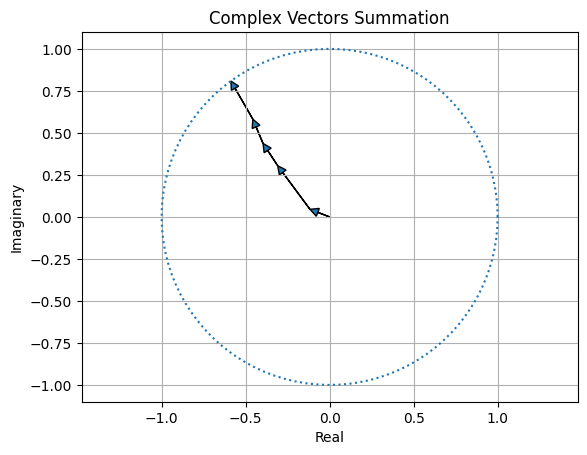

In [464]:
# Now we check that our interaction tensor works as intended
sel_state = 4

if sel_state == 0:
    selected_normalized_tensor = state_tensor
else:
    selected_normalized_tensor = transition_tensor[:,sel_state-1]
    
selected_interaction_tensor = interaction_tensor[:,:,:,sel_state]

new_transition_tensor = torch.matmul(selected_interaction_tensor,selected_normalized_tensor)

new_state_tensor = torch.matmul(new_transition_tensor, state_tensor)

plot_complex_vectors(new_state_tensor.to('cpu').numpy())

Now that this is workign as intended, let's make our function to select the normalized subgroup and associated transition matrix that will maximize the probability from going from the largest state to the smallest state. 

In [465]:
def select_transition_tensor(state_tensor,transition_tensor,interaction_tensor):
    # First we need to know which transition point we are looking for
    state_magnitudes = torch.abs(state_tensor)
    state_magnitudes_order = torch.argsort(state_magnitudes)
    to_index = state_magnitudes_order[0] # The smallest state magnitude
    from_index = state_magnitudes_order[-1] # The largest state magnitude
    
    # Next we need to go through each possible normalized subgroup and determine which one we should use
    new_transitions = []
    for sel_state in range(state_tensor.shape[0]):
        if sel_state == 0:
            selected_normalized_tensor = state_tensor
        else:
            selected_normalized_tensor = transition_tensor[:,sel_state-1]
            
        selected_interaction_tensor = interaction_tensor[:,:,:,sel_state]

        new_transition_tensor = torch.matmul(selected_interaction_tensor,selected_normalized_tensor)
        
        new_transitions.append(new_transition_tensor)
        
     # Convert list of tensors to a tensor
    new_transitions_tensor = torch.stack(new_transitions)
    
    sorted_indices = torch.argsort(torch.abs(new_transitions_tensor[:, to_index, from_index]), descending=True)
    selected_subgroup = sorted_indices[0]
    
    return new_transitions[selected_subgroup], selected_subgroup

select_transition_tensor(state_tensor,transition_tensor,interaction_tensor)

(tensor([[ 0.0091+3.4182e-01j, -0.1331+2.9785e-01j,  0.1175+6.4040e-01j,
          -0.3148+7.6369e-02j,  0.1834-5.2954e-02j],
         [ 0.1708+2.1474e-01j,  0.0481-5.8132e-03j, -0.0458+2.3127e-01j,
           0.0540+1.2628e-01j, -0.0218+8.4680e-01j],
         [ 0.0151+7.6174e-02j, -0.0551+1.1666e-01j, -0.0297+9.1795e-02j,
           0.1721+6.3626e-02j, -0.0063+6.0945e-02j],
         [ 0.1076+1.3481e-01j,  0.0570+1.2151e-01j, -0.0518+3.5438e-02j,
           0.0114+5.5700e-02j, -0.3334-6.5561e-04j],
         [-0.3026+2.3246e-01j,  0.0830+4.6979e-01j,  0.0098+1.0990e-03j,
           0.0773+6.7802e-01j,  0.1782+1.4586e-01j]], device='cuda:0',
        dtype=torch.complex128),
 tensor(0, device='cuda:0'))

Finally we just need to step through the coil

In [466]:
import time

tic = time.time()

num_steps = 30
prob_save = []
for i_step in range(num_steps):
    transition_tensor, selected_subgroup = select_transition_tensor(state_tensor,transition_tensor,interaction_tensor)
    
    state_tensor = torch.matmul(transition_tensor,state_tensor)
    state_prob = torch.real(state_tensor * torch.conj(state_tensor.sum()))
    prob_save.append(state_prob)
    print(state_prob.sum())
    # print(selected_subgroup)
    
    #plot_complex_vectors(state_tensor.to('cpu').numpy())
    
toc = time.time()    

print(f"Processing time: {round(toc-tic,4)}s")
print(state_prob.sum())

tensor(1.0000, device='cuda:0', dtype=torch.float64)
tensor(1.0000, device='cuda:0', dtype=torch.float64)
tensor(1.0000, device='cuda:0', dtype=torch.float64)
tensor(1.0000, device='cuda:0', dtype=torch.float64)
tensor(1.0000, device='cuda:0', dtype=torch.float64)
tensor(1.0000, device='cuda:0', dtype=torch.float64)
tensor(1.0000, device='cuda:0', dtype=torch.float64)
tensor(1.0000, device='cuda:0', dtype=torch.float64)
tensor(1.0000, device='cuda:0', dtype=torch.float64)
tensor(1.0000, device='cuda:0', dtype=torch.float64)
tensor(1.0000, device='cuda:0', dtype=torch.float64)
tensor(1.0000, device='cuda:0', dtype=torch.float64)
tensor(1.0000, device='cuda:0', dtype=torch.float64)
tensor(1.0000, device='cuda:0', dtype=torch.float64)
tensor(1.0001, device='cuda:0', dtype=torch.float64)
tensor(1.0001, device='cuda:0', dtype=torch.float64)
tensor(1.0001, device='cuda:0', dtype=torch.float64)
tensor(1.0002, device='cuda:0', dtype=torch.float64)
tensor(1.0004, device='cuda:0', dtype=torch.fl

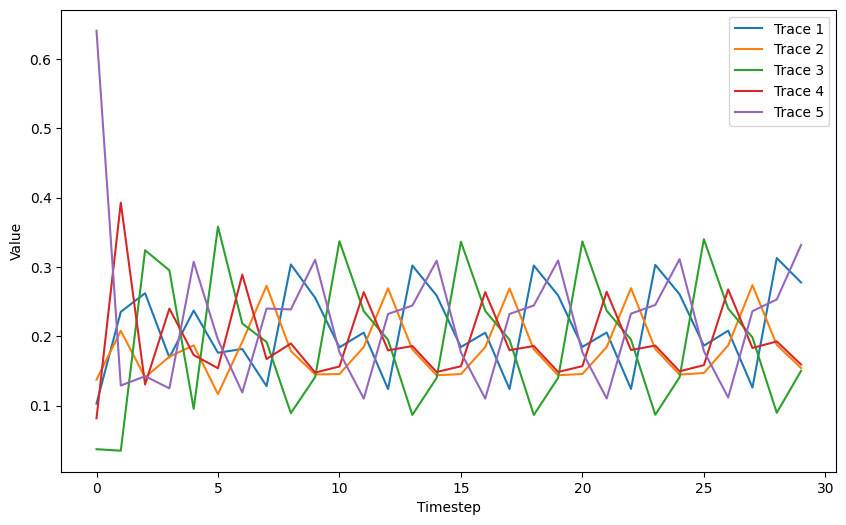

In [467]:
# Your data
data = [row.to('cpu') for row in prob_save]
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
plt.figure(figsize=(10, 6))
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Trace {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()